# Volume Forecasting : SKU future volume analysis and prediction

1. [**Introduction**](#1.-Introduction)<br>
2. [**Collection of Data**](#2.-Collection-of-Data)<br>
    [2.1 Load Data](#2.1-Load-Data)<br>
3. [**SKU Recommendation**](#3.-SKU-Recommendation)<br>
    [3.1 by weather data](#3.1-by-weather-data)<br>
    [3.2 by demographis](#3.2-by-demographis)<br>
    [3.3 combination of weather and demographis](#3.3-combination-of-weather-and-demographis)<br>
4. [**Data preparation and Data Distribution**](#4.-Data-Preparation-and-Data-Distribution)<br>
    [4.1 Check Null and Missing Values](#4.1-Check-Null-and-Missing-Values)<br>
5. [**Train Algorithm on Train Data**](#5.-Train-Algorithm-on-Train-Data)<br>
    [5.1 Validation Data](#5.1-Validation-Data)<br>
    [5.2 Modelling](#5.2-Modelling)<br>
    [5.2.1 GradientBoostingRegressor](#5.2.1-GradientBoostingRegressor)<br>
    [5.2.2 RandomForestRegressor](#5.2.3-RandomForestRegressor)<br>
    [5.2.3 Support Vector Regression](#5.2.3-Support_Vector_Regression)<br>
    [5.2.4 KNeighborsRegressor](#5.2.4-KNeighborsRegressor)<br>
    [5.2.5 XGBRegressor](#5.2.5-XGBRegressor)<br>
    [5.2.6 Linear Regression](#5.2.6-Linear-Regression)<br>
    [5.2.7 Result Modeling](#5.2.7-Result-Modeling)<br>
6. [**Test Algorithm on Test Data**](#6.-Test-Algorithm-on-Test-Data)<br> 
7. [**Forecasting Multivariate**](#7.-Forecasting-Multivariate)<br> 
    [7.1 Numerical Data Correlation](#7.1-Numerical-Data-Correlation)<br>
    [7.2 Feature Engineering](#7.2-Feature-Engineering)<br>
    [7.3 Modelling](#7.3-Modelling)<br>
8. [**Forecasting Unvariate**](#8.-Forecasting-Unvariate)<br>
        

## 1. Introduction

Country Beeristan, a high potential market, accounts for nearly 10% of Stallion & Co.’s global beer sales. Stallion & Co. has a large portfolio of products distributed to retailers through wholesalers (agencies). There are thousands of unique wholesaler-SKU/products combinations. In order to plan its production and distribution as well as help wholesalers with their planning, it is important for Stallion & Co. to have an accurate estimate of demand at SKU level for each wholesaler.<br>

Currently demand is estimated by sales executives, who generally have a “feel” for the market and predict the net effect of forces of supply, demand and other external factors based on past experience. The more experienced a sales exec is in a particular market, the better a job he does at estimating. Joshua, the new Head of S&OP for Stallion & Co. just took an analytics course and realized he can do the forecasts in a much more effective way. He approaches you, the best data scientist at Stallion, to transform the exercise of demand forecasting.<br>

$\textbf{Arif Romadhan}$ <br>
email : arifromadhan19@gmail.com<br><br>
[Link my kaggle](https://www.kaggle.com/utathya/future-volume-prediction)<br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import joblib
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


from math import sqrt
from numpy import concatenate

from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## 2. Collection of Data

###  2.1 Load Data

### Data Training

In [29]:
df1 = pd.read_csv('../input/demographics.csv')
df1['Year'] = '2017'
print(len(df1))
df1.head(2)

60


,Agency,Avg_Population_2017,Avg_Yearly_Household_Income_2017,Year
0,Agency_05,3044268,182944,2017
1,Agency_02,3137874,240809,2017


In [10]:
df2 = pd.read_csv('../input/event_calendar.csv')
print(len(df2))
df2['YearMonth'] = df2['YearMonth'] .astype(str)
df2['YearMonth'] = df2['YearMonth'].apply(lambda x: x[0:4]+'-'+x[4:6])
df2['YearMonth']  = pd.to_datetime(df2['YearMonth'])
df2.head(2)

61


,YearMonth,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
0,2013-01-01,0,0,1,0,0,0,0,0,0,0,0,0
1,2013-02-01,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df3 = pd.read_csv('../input/historical_volume.csv')
print(len(df3))
df3['YearMonth'] = df3['YearMonth'] .astype(str)
df3['YearMonth'] = df3['YearMonth'].apply(lambda x: x[0:4]+'-'+x[4:6])
df3['YearMonth']  = pd.to_datetime(df3['YearMonth'])
df3 = df3.sort_values('YearMonth', ascending=True).reset_index(drop=True)
df3.head(2)

21000


,Agency,SKU,YearMonth,Volume
0,Agency_22,SKU_01,2013-01-01,52.272
1,Agency_37,SKU_04,2013-01-01,0.000


In [5]:
df4 = pd.read_csv('../input/industry_soda_sales.csv')
print(len(df4))
df4['YearMonth'] = df4['YearMonth'] .astype(str)
df4['YearMonth'] = df4['YearMonth'].apply(lambda x: x[0:4]+'-'+x[4:6])
df4['YearMonth']  = pd.to_datetime(df4['YearMonth'])
df4.head(2)

60


,YearMonth,Soda_Volume
0,2013-01-01,718394219
1,2013-02-01,753938444


In [9]:
df5 = pd.read_csv('../input/industry_volume.csv')
print(len(df5))
df5['YearMonth'] = df5['YearMonth'] .astype(str)
df5['YearMonth'] = df5['YearMonth'].apply(lambda x: x[0:4]+'-'+x[4:6])
df5['YearMonth']  = pd.to_datetime(df5['YearMonth'])
df5.head(2)

60


,YearMonth,Industry_Volume
0,2013-01-01,492612703
1,2013-02-01,431937346


In [6]:
df6 = pd.read_csv('../input/price_sales_promotion.csv')
print(len(df6))
df6['YearMonth'] = df6['YearMonth'] .astype(str)
df6['YearMonth'] = df6['YearMonth'].apply(lambda x: x[0:4]+'-'+x[4:6])
df6['YearMonth']  = pd.to_datetime(df6['YearMonth'])
df6 = df6.sort_values('YearMonth', ascending=True).reset_index(drop=True)
df6.head(2)

21000


,Agency,SKU,YearMonth,Price,Sales,Promotions
0,Agency_01,SKU_01,2013-01-01,1141.500000,1033.432731,108.067269
1,Agency_28,SKU_05,2013-01-01,1534.647887,1534.647887,0.000000


In [18]:
df7 = pd.read_csv('../input/weather.csv')
print(len(df7))
df7['YearMonth'] = df7['YearMonth'] .astype(str)
df7['YearMonth'] = df7['YearMonth'].apply(lambda x: x[0:4]+'-'+x[4:6])
df7['YearMonth']  = pd.to_datetime(df7['YearMonth'])
df7.head(2)

3600


,YearMonth,Agency,Avg_Max_Temp
0,2013-01-01,Agency_01,17.072
1,2013-02-01,Agency_01,19.984


#### Merge industry_soda_sales, industry_volume

In [10]:
dfa = df4.merge(df5, on='YearMonth', how='inner')
dfa = dfa.merge(df2, on='YearMonth', how='inner')
print(len(dfa))
dfa.head(2)

60


,YearMonth,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
0,2013-01-01,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
1,2013-02-01,753938444,431937346,0,0,0,0,0,0,0,0,0,0,0,0


#### Merge historical_volume, price_sales_promotion, weather, industry_soda_sales, industry_volume

In [12]:
df = df3.merge(df6, on=['Agency','SKU','YearMonth'], how='inner')
df = df.merge(df7, on=['Agency','YearMonth'], how='inner')

df['Year'] = df['YearMonth'].dt.year
df['Year'] = df['Year'].astype(str)

print(len(df))
df = df.merge(df1, on=['Agency','Year'], how ='left')

print(len(df))
df['SKU'] = df['SKU'].apply(lambda x: x[4:])
df['SKU'] = df['SKU'].astype(int)

df['Agency'] = df['Agency'].apply(lambda x: x[7:])
df['Agency'] = df['Agency'].astype(int)

df = df.merge(dfa, on='YearMonth', how='left')
df = df.drop('Year', axis=1)
print(len(df))

df.to_csv('../input/train.csv',index=False)
df.head(2)

21000
21000
21000


,Agency,SKU,YearMonth,Volume,Price,Sales,Promotions,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,...,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
0,22,1,2013-01-01,52.2720,1168.903668,1069.166193,99.737475,25.845238,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,22,4,2013-01-01,31.0554,1742.112676,1598.414189,143.698487,25.845238,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


## 3. SKU Recommendation

### 3.1 by weather data

In [19]:
# df7['Agency'] = df7['Agency'].apply(lambda x: x[7:])
# df7['Agency'] = df7['Agency'].astype(int)
print(len(df7))
df7.head(3)

3600


,YearMonth,Agency,Avg_Max_Temp
0,2013-01-01,Agency_01,17.072
1,2013-02-01,Agency_01,19.984
2,2013-03-01,Agency_01,24.600


In [20]:
df7 = df7.groupby('Agency')['Avg_Max_Temp'].agg(['mean','median']).reset_index()
print(len(df7))
df7.head(3)

60


,Agency,mean,median
0,Agency_01,26.454848,27.451417
1,Agency_02,30.292461,30.887660
2,Agency_03,29.006522,29.746955


In [21]:
agen6 = df7[(df7['mean']>=29.007939)&(df7['mean'] <29.007940)].reset_index(drop=True)
agen6

,Agency,mean,median
0,Agency_05,29.007939,28.791272
1,Agency_06,29.007939,28.791272
2,Agency_08,29.007939,28.791272
3,Agency_40,29.007939,28.791272
4,Agency_50,29.007939,28.791272


In [22]:
agen14 = df7[(df7['mean']>= 25.085280)&(df7['mean'] <25.085282)].reset_index(drop=True)
agen14

,Agency,mean,median
0,Agency_12,25.085281,24.977237
1,Agency_13,25.085281,24.977237
2,Agency_14,25.085281,24.977237
3,Agency_15,25.085281,24.977237
4,Agency_16,25.085281,24.977237
5,Agency_17,25.085281,24.977237
6,Agency_20,25.085281,24.977237
7,Agency_38,25.085281,24.977237
8,Agency_39,25.085281,24.977237
9,Agency_57,25.085281,24.977237


**jika kita analisa by mean dan median<br>
Agency 6 memiliki kesamaan dengan agency 5, 40, 8, dan 50<br>
Agency 14 memiliki kesamaan dengan agency 12, 13, 15, 16. 17, 20, 38, 39, 57, 58, 59, 60**

### 3.2 by demographis

In [30]:
df1 = df1.drop('Year',axis=1)
df1 = df1.sort_values('Agency',ascending=True).reset_index(drop=True)
df1.head(2)

,Agency,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,Agency_01,153733,120207
1,Agency_02,3137874,240809


In [31]:
agen_614 = df1[(df1['Agency']=='Agency_06')|(df1['Agency']=='Agency_14')]
agen_614

,Agency,Avg_Population_2017,Avg_Yearly_Household_Income_2017
5,Agency_06,2104390,228353
13,Agency_14,2073615,204289


In [32]:
df1_temp = df1[(df1['Avg_Population_2017'] >= 1800000)]
df1_temp = df1_temp[(df1_temp['Avg_Population_2017'] < 2500000)]
df1_temp.head(2)

,Agency,Avg_Population_2017,Avg_Yearly_Household_Income_2017
5,Agency_06,2104390,228353
6,Agency_07,1868030,175785


In [33]:
df1_temp = df1_temp[df1_temp['Avg_Yearly_Household_Income_2017']> 185000]
df1_temp = df1_temp[df1_temp['Agency'] != 'Agency_06']
df1_temp = df1_temp[df1_temp['Agency'] != 'Agency_14'].reset_index(drop=True)
df1_temp.head(2)

,Agency,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,Agency_55,2025793,238553
1,Agency_56,1901290,206553


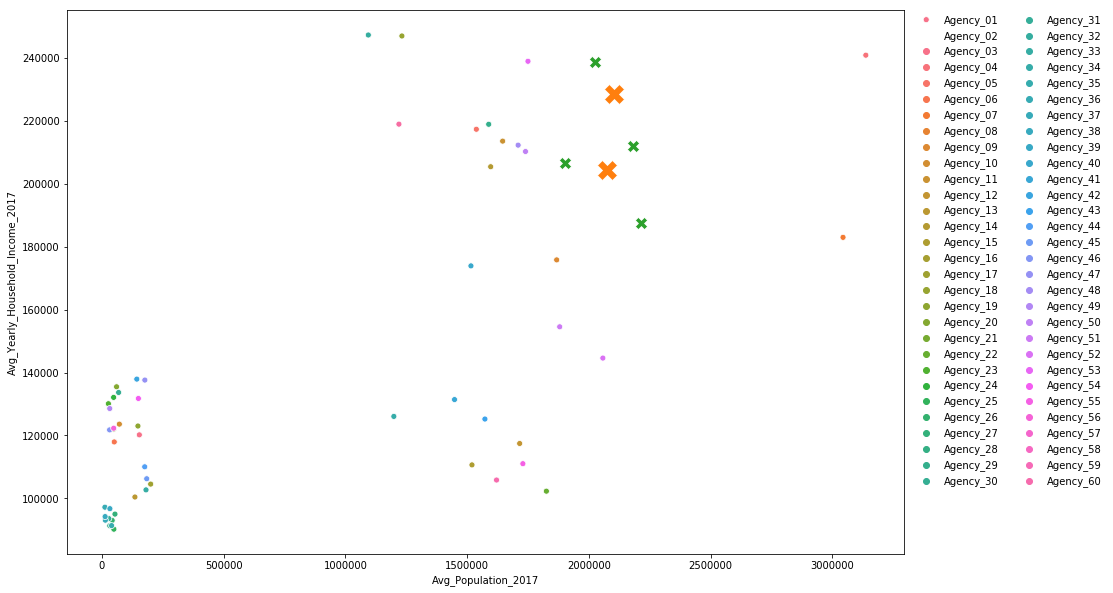

In [34]:
fig, ax = plt.subplots(figsize=(15,10), sharex=True, sharey=True)
g = sns.scatterplot(x='Avg_Population_2017',y='Avg_Yearly_Household_Income_2017', hue='Agency', data=df1, ax=ax)
g = sns.scatterplot(x='Avg_Population_2017',y='Avg_Yearly_Household_Income_2017', marker='X', s=400 , data=agen_614, ax=ax)
g = sns.scatterplot(x='Avg_Population_2017',y='Avg_Yearly_Household_Income_2017', marker='X', s=150 , data=df1_temp, ax=ax)


ax.legend( df1['Agency'].values, loc='upper lef', ncol=2, borderaxespad=0,frameon=False, bbox_to_anchor= (1.01, 1.0))
plt.savefig('../fig/sku reco analysis 1.png',bbox_inches='tight')

**jika kita analisa dari graph tersebut maka,<br>
Agency_06 dekat dengan agency 55 dan 60<br>
Agency_14 dekat dengan 57 dan 56**

### 3.3 combination of weather and demographis

**dari kedua hasil analisa tersebut maka<br>
Agency_06 : 55, 60, 5, 40, 8, dan 50<br>
Agency_14 : 57, 56, 12, 13, 15, 16. 17, 20, 38, 39, 57, 58, 59, 60<br><br>
Mencari SKU dengan volume terbaik dari agency diatas di dalam data historical_volume**

### Agency_06

In [59]:
agen6 = df3[df3['Agency'].isin(['Agency_55','Agency_60','Agency_5','Agency_40','Agency_8','Agency_50'])]
agen6 = agen6.sort_values('Agency', ascending=True).reset_index(drop=True)
agen6 = agen6.drop('YearMonth',axis=1)
print(len(agen6))
agen6.head()

1260


,Agency,SKU,Volume
0,Agency_40,SKU_03,24.36480
1,Agency_40,SKU_18,0.93060
2,Agency_40,SKU_03,20.13480
3,Agency_40,SKU_03,3.98325
4,Agency_40,SKU_04,0.00000


In [60]:
agen6 = agen6.groupby(['Agency','SKU'])['Volume'].agg(['mean','median']).reset_index()
agen6 = agen6.drop('Agency',axis=1)
agen6.head()

,SKU,mean,median
0,SKU_03,16.560648,18.18900
1,SKU_04,130.185185,1.66140
2,SKU_18,0.260850,0.00000
3,SKU_01,1595.824200,1585.81800
4,SKU_02,12647.808475,13086.41625


In [42]:
# agen6['SKU'].value_counts()

In [61]:
agen6 = agen6.groupby('SKU')['mean','median'].mean().reset_index()
agen6 = agen6.sort_values('mean', ascending=False).reset_index(drop=True)
agen6.head(6)

,SKU,mean,median
0,SKU_02,6193.731158,6277.464750
1,SKU_01,5983.209633,5996.789750
2,SKU_05,2170.522213,2072.340800
3,SKU_04,1784.643742,1683.655538
4,SKU_03,1650.598311,1534.315631
5,SKU_07,72.459375,71.242500


### Agency_14

In [62]:
dagen14 = df3[df3['Agency'].isin(['Agency_57','Agency_56','Agency_12','Agency_13','Agency_15',
                                    'Agency_16','Agency_17','Agency_20','Agency_38','Agency_39',
                                    'Agency_58','Agency_59','Agency_60'])]
print(len(dagen14))
dagen14.head()

5220


,Agency,SKU,YearMonth,Volume
2,Agency_59,SKU_03,2013-01-01,812.9214
7,Agency_57,SKU_03,2013-01-01,782.1270
11,Agency_16,SKU_05,2013-01-01,1160.2962
14,Agency_16,SKU_02,2013-01-01,3.2400
15,Agency_56,SKU_04,2013-01-01,1683.8928


In [63]:
dagen14 = dagen14.sort_values('Agency', ascending=True).reset_index(drop=True)
dagen14 = dagen14.drop('YearMonth',axis=1)
dagen14.head()

,Agency,SKU,Volume
0,Agency_12,SKU_04,1927.9905
1,Agency_12,SKU_03,403.9971
2,Agency_12,SKU_04,1773.0555
3,Agency_12,SKU_04,3238.9635
4,Agency_12,SKU_01,11008.3320


In [64]:
dagen14 = dagen14.groupby(['Agency','SKU'])['Volume'].agg(['mean','median']).reset_index()
dagen14.head()

,Agency,SKU,mean,median
0,Agency_12,SKU_01,11622.589450,11158.560000
1,Agency_12,SKU_02,5190.297950,4591.134000
2,Agency_12,SKU_03,610.989262,601.759800
3,Agency_12,SKU_04,1650.180670,1579.639875
4,Agency_12,SKU_05,2184.550520,2044.320900


In [65]:
dagen14 = dagen14.drop('Agency',axis=1)
dagen14.head()

,SKU,mean,median
0,SKU_01,11622.589450,11158.560000
1,SKU_02,5190.297950,4591.134000
2,SKU_03,610.989262,601.759800
3,SKU_04,1650.180670,1579.639875
4,SKU_05,2184.550520,2044.320900


In [45]:
# dagen14['SKU'].value_counts()

In [66]:
dagen14 = dagen14.groupby('SKU')['mean','median'].mean().reset_index()
dagen14 = dagen14.sort_values('mean', ascending=False).reset_index(drop=True)
dagen14.head(6)

,SKU,mean,median
0,SKU_01,6723.254260,6620.080269
1,SKU_02,4198.843581,4004.303596
2,SKU_05,2056.585302,1994.280513
3,SKU_04,1465.389153,1405.363235
4,SKU_03,1008.132432,994.888350
5,SKU_07,40.521200,40.090500


## 4. Data Preparation and Data Distribution

In [67]:
df = pd.read_csv('../input/train.csv')
df['Volume'] = df['Volume'].round(2)
df['Price'] = df['Price'].round(2)
df['Sales'] = df['Sales'].round(2)
df['Promotions'] = df['Promotions'].round(2)
df['Avg_Max_Temp'] = df['Avg_Max_Temp'].round(2)
df.head()

,Agency,SKU,YearMonth,Volume,Price,Sales,Promotions,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,...,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
0,22,1,2013-01-01,52.27,1168.90,1069.17,99.74,25.85,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,22,4,2013-01-01,31.06,1742.11,1598.41,143.70,25.85,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,22,5,2013-01-01,238.54,1310.18,1203.88,106.30,25.85,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
3,22,2,2013-01-01,110.70,1167.00,1067.26,99.74,25.85,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
4,22,3,2013-01-01,86.46,1258.73,1156.65,102.08,25.85,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [71]:
df = df[['Agency','SKU','Volume']].copy()
df.head()

,Agency,SKU,Volume
0,22,1,52.27
1,22,4,31.06
2,22,5,238.54
3,22,2,110.70
4,22,3,86.46


### 4.1 Check Null and Missing Values

In [72]:
df.isnull().sum()

Agency    0
SKU       0
Volume    0
dtype: int64

## 5. Train Algorithm on Train Data

In [110]:
X = df.iloc[:,0:2]
X.head(2)

,Agency,SKU
0,22,1
1,22,4


In [111]:
y = df.iloc[:,2:3]
y.head(2)

,Volume
0,52.27
1,31.06


In [112]:
sc_x = StandardScaler()

X = sc_x.fit_transform(X.astype(float))
y = y.values

### 5.1 Validation Data

In [113]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(14070, 2)
(14070, 1)
(6930, 2)
(6930, 1)


In [114]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

### 5.2 Modelling

### 5.2.1 GradientBoostingRegressor

In [84]:
arr_gb_val_r2 = []
arr_gb_val_mse = []

arr_gb_test_r2 = []
arr_gb_test_mse = []

for train, test in kfold.split(X_train):
    clf_gb = GradientBoostingRegressor()
    clf_gb.fit(X[train],y[train])

    Y_pred_val = clf_gb.predict(X[test])
    val_mse_gb = mean_squared_error(y[test],Y_pred_val)
    val_r2_gb = r2_score(y[test], Y_pred_val) 

    print('r2 Val : ',val_r2_gb)
    print('mse Val : ',val_mse_gb)
    arr_gb_val_r2.append(val_r2_gb)
    arr_gb_val_mse.append(val_mse_gb)
    
    Y_pred_test = clf_gb.predict(X_test)
    test_mse_gb = mean_squared_error(Y_test,Y_pred_test)
    test_r2_gb = r2_score(Y_test, Y_pred_test) 

    print('r2 Test : ',test_r2_gb)
    print('mse Val : ',test_mse_gb)
    arr_gb_test_r2.append(test_r2_gb)
    arr_gb_test_mse.append(test_mse_gb)



r2 Val :  0.637226608034432
mse Val :  2254975.4762185896
r2 Test :  0.6041968932152377
mse Val :  2885408.5190598685
r2 Val :  0.6122585764355655
mse Val :  2569351.6843681987
r2 Test :  0.6026456120908792
mse Val :  2896717.373626579
r2 Val :  0.6330231270772125
mse Val :  2767965.8037048657
r2 Test :  0.6149617728427607
mse Val :  2806932.4413043708
r2 Val :  0.6133834463253734
mse Val :  2837063.209372403
r2 Test :  0.5958896000339139
mse Val :  2945968.767589587
r2 Val :  0.6308702958681346
mse Val :  2629606.16193099
r2 Test :  0.6071107126835651
mse Val :  2864166.7466412247


In [85]:
print(np.mean(arr_gb_val_r2))
print(np.mean(arr_gb_val_mse))
print(np.mean(arr_gb_test_r2))
print(np.mean(arr_gb_test_mse))

0.6253524107481436
2611792.4671190092
0.6049609181732712
2879838.7696443256


### 5.2.2 RandomForestRegressor

In [86]:
arr_rf_val_r2 = []
arr_rf_val_mse = []

arr_rf_test_r2 = []
arr_rf_test_mse = []

for train, test in kfold.split(X_train):
    clf_rf = RandomForestRegressor(n_estimators=500, random_state=0,max_depth=2)
    clf_rf.fit(X[train],y[train])

    Y_pred_val = clf_rf.predict(X[test])
    val_mse_rf = mean_squared_error(y[test],Y_pred_val)
    val_r2_rf = r2_score(y[test], Y_pred_val) 

    print('r2 Val : ',val_r2_rf)
    print('mse Val : ',val_mse_rf)
    arr_rf_val_r2.append(val_r2_rf)
    arr_rf_val_mse.append(val_mse_rf)
    
    Y_pred_test = clf_rf.predict(X_test)
    test_mse_rf = mean_squared_error(Y_test,Y_pred_test)
    test_r2_rf = r2_score(Y_test, Y_pred_test) 

    print('r2 Test : ',test_r2_rf)
    print('mse Val : ',test_mse_rf)
    arr_rf_test_r2.append(test_r2_rf)
    arr_rf_test_mse.append(test_mse_rf)



r2 Val :  0.1766405257153858
mse Val :  5117948.184028492
r2 Test :  0.18012117314977372
mse Val :  5976924.665416822
r2 Val :  0.19474716273983061
mse Val :  5335972.913951163
r2 Test :  0.18878713844804074
mse Val :  5913749.693647097
r2 Val :  0.18183282594162298
mse Val :  6171121.197558196
r2 Test :  0.18579952378062148
mse Val :  5935529.433788772
r2 Val :  0.175348736439512
mse Val :  6051442.283505802
r2 Test :  0.18309580981384788
mse Val :  5955239.535046446
r2 Val :  0.19191884378689772
mse Val :  5756608.487295281
r2 Test :  0.19615618877013807
mse Val :  5860029.244736312


In [87]:
print(np.mean(arr_rf_val_r2))
print(np.mean(arr_rf_val_mse))
print(np.mean(arr_rf_test_r2))
print(np.mean(arr_rf_test_mse))

0.18409761892464982
5686618.613267787
0.1867919667924844
5928294.51452709


### 5.2.3 Support Vector Regression

In [88]:
arr_svm_val_r2 = []
arr_svm_val_mse = []

arr_svm_test_r2 = []
arr_svm_test_mse = []

for train, test in kfold.split(X_train):
    clf_svm = SVR(kernel='rbf', C=1e3, gamma=0.1)
    clf_svm.fit(X[train],y[train])

    Y_pred_val = clf_svm.predict(X[test])
    val_mse_svm = mean_squared_error(y[test],Y_pred_val)
    val_r2_svm = r2_score(y[test], Y_pred_val) 

    print('r2 Val : ',val_r2_svm)
    print('mse Val : ',val_mse_svm)
    arr_svm_val_r2.append(val_r2_svm)
    arr_svm_val_mse.append(val_mse_svm)
    
    Y_pred_test = clf_svm.predict(X_test)
    test_mse_svm = mean_squared_error(Y_test,Y_pred_test)
    test_r2_svm = r2_score(Y_test, Y_pred_test) 

    print('r2 Test : ',test_r2_svm)
    print('mse Val : ',test_mse_svm)
    arr_svm_test_r2.append(test_r2_svm)
    arr_svm_test_mse.append(test_mse_svm)



r2 Val :  0.0722548360723495
mse Val :  5766802.745653985
r2 Test :  0.03401644955209093
mse Val :  7042029.529216924
r2 Val :  0.03589451935119192
mse Val :  6388603.048500391
r2 Test :  0.03524882700540155
mse Val :  7033045.485530744
r2 Val :  0.007249136015245239
mse Val :  7487939.011585682
r2 Test :  0.028168951352026905
mse Val :  7084657.848278672
r2 Val :  0.04015884859502328
mse Val :  7043490.485884552
r2 Test :  0.03189735980392794
mse Val :  7057477.714203826
r2 Val :  0.0098083677808396
mse Val :  7053927.084247437
r2 Test :  0.028066750839463306
mse Val :  7085402.89101469


In [89]:
print(np.mean(arr_svm_val_r2))
print(np.mean(arr_svm_val_mse))
print(np.mean(arr_svm_test_r2))
print(np.mean(arr_svm_test_mse))

0.03307314156292991
6748152.475174409
0.031479667710582124
7060522.693648972


### 5.2.4 KNeighborsRegressor

In [90]:
arr_knn_val_r2 = []
arr_knn_val_mse = []

arr_knn_test_r2 = []
arr_knn_test_mse = []

for train, test in kfold.split(X_train):
    clf_knn = KNeighborsRegressor(n_neighbors=2)
    clf_knn.fit(X[train],y[train])

    Y_pred_val = clf_knn.predict(X[test])
    val_mse_knn = mean_squared_error(y[test],Y_pred_val)
    val_r2_knn = r2_score(y[test], Y_pred_val) 

    print('r2 Val : ',val_r2_knn)
    print('mse Val : ',val_mse_knn)
    arr_knn_val_r2.append(val_r2_knn)
    arr_knn_val_mse.append(val_mse_knn)
    
    Y_pred_test = clf_knn.predict(X_test)
    test_mse_knn = mean_squared_error(Y_test,Y_pred_test)
    test_r2_knn = r2_score(Y_test, Y_pred_test) 

    print('r2 Test : ',test_r2_knn)
    print('mse Val : ',test_mse_knn)
    arr_knn_test_r2.append(test_r2_knn)
    arr_knn_test_mse.append(test_mse_knn)



r2 Val :  0.9258747077660873
mse Val :  460757.9272817075
r2 Test :  0.914621250753764
mse Val :  622411.9169325577
r2 Val :  0.9318422771981878
mse Val :  451644.1866687367
r2 Test :  0.9092248603394635
mse Val :  661751.6558246608
r2 Val :  0.9297851537788767
mse Val :  529603.6551419331
r2 Test :  0.9129719756912134
mse Val :  634435.1482669805
r2 Val :  0.9179241078650698
mse Val :  602287.9562171997
r2 Test :  0.9086519557708842
mse Val :  665928.1357320959
r2 Val :  0.9123519953558905
mse Val :  624386.8496986941
r2 Test :  0.9024392725920183
mse Val :  711218.6568604906


In [91]:
print(np.mean(arr_knn_val_r2))
print(np.mean(arr_knn_val_mse))
print(np.mean(arr_knn_test_r2))
print(np.mean(arr_knn_test_mse))

0.9235556483928224
533736.1150016541
0.9095818630294688
659149.102723357


### 5.2.5 XGBRegressor

In [115]:
arr_xgb_val_r2 = []
arr_xgb_val_mse = []

arr_xgb_test_r2 = []
arr_xgb_test_mse = []

i = 1
for train, test in kfold.split(X_train):
    clf_xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7)
    clf_xgb.fit(X[train],y[train])
    #save model
    joblib.dump(clf_xgb, '../model/xgb_'+str(i)+'.dat') 
    i = i+1
    
    Y_pred_val = clf_xgb.predict(X[test])
    val_mse_xgb = mean_squared_error(y[test],Y_pred_val)
    val_r2_xgb = r2_score(y[test], Y_pred_val) 

    print('r2 Val : ',val_r2_xgb)
    print('mse Val : ',val_mse_xgb)
    arr_xgb_val_r2.append(val_r2_xgb)
    arr_xgb_val_mse.append(val_mse_xgb)
    
    Y_pred_test = clf_xgb.predict(X_test)
    test_mse_xgb = mean_squared_error(Y_test,Y_pred_test)
    test_r2_xgb = r2_score(Y_test, Y_pred_test) 

    print('r2 Test : ',test_r2_xgb)
    print('mse Val : ',test_mse_xgb)
    arr_xgb_test_r2.append(test_r2_xgb)
    arr_xgb_test_mse.append(test_mse_xgb)



r2 Val :  0.9387707354292832
mse Val :  380597.06993883045
r2 Test :  0.9228256464820828
mse Val :  562601.7918414912
r2 Val :  0.9479241167215813
mse Val :  345078.5763005586
r2 Test :  0.9231087233494086
mse Val :  560538.1587104477
r2 Val :  0.9398528562845015
mse Val :  453666.8364658785
r2 Test :  0.9218999554963085
mse Val :  569350.0881802116
r2 Val :  0.9423889464638692
mse Val :  422760.48163756524
r2 Test :  0.9233745414164405
mse Val :  558600.3424023235
r2 Val :  0.9448809129979491
mse Val :  392657.34834719676
r2 Test :  0.9236962062356651
mse Val :  556255.4027245832


In [93]:
print(np.mean(arr_xgb_val_r2))
print(np.mean(arr_xgb_val_mse))
print(np.mean(arr_xgb_test_r2))
print(np.mean(arr_xgb_test_mse))

0.9427635135794368
398952.06253800594
0.922981014595981
561469.1567718114


### 5.2.6 Linear Regression

In [94]:
arr_lr_val_r2 = []
arr_lr_val_mse = []

arr_lr_test_r2 = []
arr_lr_test_mse = []

for train, test in kfold.split(X_train):
    clf_lr = LinearRegression()
    clf_lr.fit(X[train],y[train])

    Y_pred_val = clf_lr.predict(X[test])
    val_mse_lr = mean_squared_error(y[test],Y_pred_val)
    val_r2_lr = r2_score(y[test], Y_pred_val) 

    print('r2 Val : ',val_r2_lr)
    print('mse Val : ',val_mse_lr)
    arr_lr_val_r2.append(val_r2_lr)
    arr_lr_val_mse.append(val_mse_lr)
    
    Y_pred_test = clf_lr.predict(X_test)
    test_mse_lr = mean_squared_error(Y_test,Y_pred_test)
    test_r2_lr = r2_score(Y_test, Y_pred_test) 

    print('r2 Test : ',test_r2_lr)
    print('mse Val : ',test_mse_lr)
    arr_lr_test_r2.append(test_r2_lr)
    arr_lr_test_mse.append(test_mse_lr)



r2 Val :  0.08216234277975165
mse Val :  5705218.337451899
r2 Test :  0.08337307966202312
mse Val :  6682219.213051998
r2 Val :  0.08826482298054683
mse Val :  6041573.508545662
r2 Test :  0.08342375563155746
mse Val :  6681849.784738527
r2 Val :  0.08498958326413641
mse Val :  6901572.634228362
r2 Test :  0.08321471522250856
mse Val :  6683373.691364721
r2 Val :  0.08071073621643754
mse Val :  6745913.2938377205
r2 Test :  0.08352696317533126
mse Val :  6681097.400735139
r2 Val :  0.0811282669535095
mse Val :  6545858.391228484
r2 Test :  0.0834285896316398
mse Val :  6681814.544830655


In [95]:
print(np.mean(arr_lr_val_r2))
print(np.mean(arr_lr_val_mse))
print(np.mean(arr_lr_test_r2))
print(np.mean(arr_lr_test_mse))

0.08345115043887638
6388027.233058425
0.08339342066461204
6682070.926944208


### 5.2.7 Result Modeling

In [99]:
result_modelling = pd.DataFrame({
    'model': ['GradientBoostingRegressor', 'RandomForestRegressor', 'Support Vector Regression', 
            'KNeighborsRegressor', 'XGBRegressor', 'Linear Regression'
             ],
    'val mse': [np.mean(arr_gb_val_mse), np.mean(arr_rf_val_mse), np.mean(arr_svm_val_mse),
                np.mean(arr_knn_val_mse), np.mean(arr_xgb_val_mse), np.mean(arr_lr_val_mse)
        
    ],
    
    'val r2': [np.mean(arr_gb_val_r2), np.mean(arr_rf_val_r2), np.mean(arr_svm_val_r2),
               np.mean(arr_knn_val_r2), np.mean(arr_xgb_val_r2), np.mean(arr_lr_val_r2)
        
    ],
    'test mse': [np.mean(arr_gb_test_mse), np.mean(arr_rf_test_mse), np.mean(arr_svm_test_mse),
                 np.mean(arr_knn_test_mse), np.mean(arr_xgb_test_mse), np.mean(arr_lr_test_mse)
        
    ],
    
    'test r2': [np.mean(arr_gb_test_r2), np.mean(arr_rf_test_r2), np.mean(arr_svm_test_r2),
                np.mean(arr_knn_test_r2), np.mean(arr_xgb_test_r2), np.mean(arr_lr_test_r2)
        
    ],
})
result_modelling['val mse'] = np.round(result_modelling['val mse'], decimals = 3)
result_modelling['val r2'] = np.round(result_modelling['val r2'], decimals = 3)
result_modelling['test mse'] = np.round(result_modelling['test mse'], decimals = 3)
result_modelling['test r2'] = np.round(result_modelling['test r2'], decimals = 3)
result_modelling = result_modelling.sort_values(by='val r2', ascending=False).reset_index(drop=True)
result_modelling

,model,val mse,val r2,test mse,test r2
0,XGBRegressor,398952.063,0.943,561469.157,0.923
1,KNeighborsRegressor,533736.115,0.924,659149.103,0.910
2,GradientBoostingRegressor,2611792.467,0.625,2879838.770,0.605
3,RandomForestRegressor,5686618.613,0.184,5928294.515,0.187
4,Linear Regression,6388027.233,0.083,6682070.927,0.083
5,Support Vector Regression,6748152.475,0.033,7060522.694,0.031


In [144]:
result_modelling.to_csv('../result/result_modelling.csv',index=False)

In [147]:
val = result_modelling['val r2']
test = result_modelling['test r2']

bars = result_modelling['model']
barwidth = 0.3

total_pos = np.arange(len(bars))
val_pos = [x + barwidth for x in total_pos]
test_pos = [x + 2*barwidth for x in total_pos]


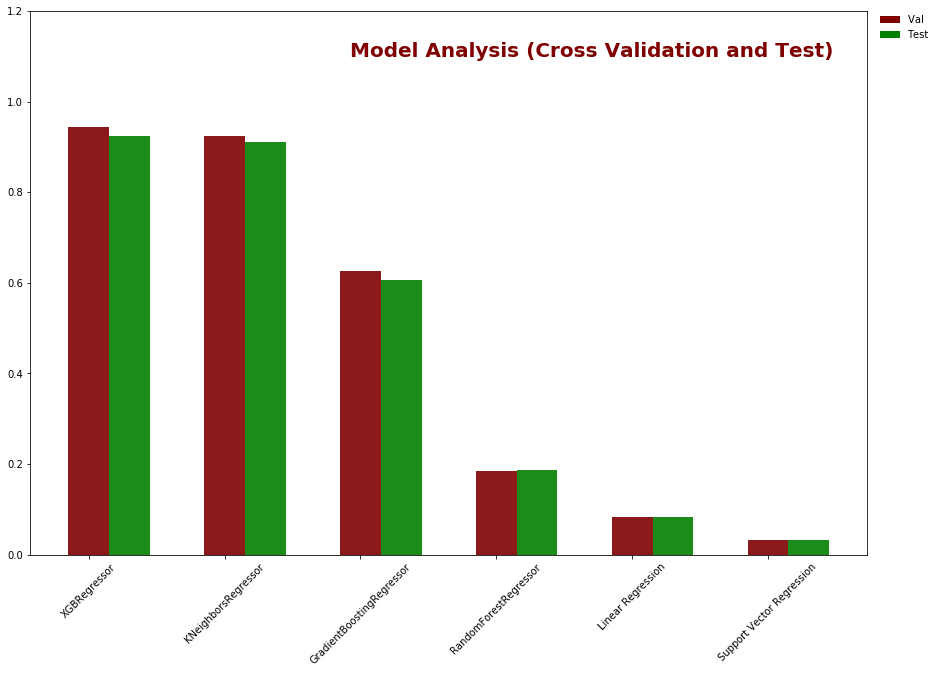

In [159]:
fig,ax =plt.subplots(figsize=(15,10))
plt.bar(val_pos,val,width=barwidth, color = '#800000', alpha=0.9)
plt.bar(test_pos,test,width=barwidth, color = '#008000', alpha=0.9)

plt.bar(0.3,0,width=barwidth, color = '#800000',label='Val ')
plt.bar(0.6,0,width=barwidth, color = '#008000', label='Test ')
# plt.bar(0.3,0.9450,width=barwidth, color = '#800000')
# plt.bar(0.6,0.946977,width=barwidth, color = '#008000')

title = 'Model Analysis (Cross Validation and Test)'
txpos = 4 #title x coordinate
typos = 1.1 #title y coordinate
ax.text(txpos,typos,title,horizontalalignment='center',color='#800000',fontsize=20,fontweight='bold')


# insight = '''

# '''
# ixpos = 0.1 #insight x coordinate
# iypos = 1.05 #insight y coordinate
# ax.text(ixpos,iypos,insight,horizontalalignment='left',color='grey',fontsize=16,fontweight='normal')

plt.xticks(val_pos, bars,rotation=45)
ax.legend(loc='upper left', bbox_to_anchor= (1.01, 1.0), ncol=1, borderaxespad=0,frameon=False)
ax.set_ylim(0,1.2)




plt.savefig('../fig/result_modelling.png',bbox_inches='tight')

## 6. Test Algorithm on Test Data

In [139]:
df_test = pd.read_csv('../input/volume_forecast.csv')
df_test.head(2)

,Agency,SKU,Volume
0,Agency_23,SKU_06,NaN
1,Agency_34,SKU_20,NaN


In [118]:
df_test.isnull().sum()

Agency       0
SKU          0
Volume    1450
dtype: int64

In [119]:
df_test['SKU'] = df_test['SKU'].apply(lambda x: x[4:])
df_test['SKU'] = df_test['SKU'].astype(int)

df_test['Agency'] = df_test['Agency'].apply(lambda x: x[7:])
df_test['Agency'] = df_test['Agency'].astype(int)
df_test.head(2)

,Agency,SKU,Volume
0,23,6,NaN
1,34,20,NaN


In [120]:
df_test = df_test.drop('Volume', axis=1)

In [121]:
X_test = sc_x.fit_transform(df_test.astype(float))

In [122]:
model_xgb = joblib.load('../model/xgb_2.dat')

In [136]:
y_pred = model_xgb.predict(X_test)
y_pd = pd.DataFrame({'Volume':y_pred})
print('finish predict')
y_pd.head()

finish predict


,Volume
0,42.544613
1,-124.071152
2,40.357155
3,4866.079102
4,-70.283180


### Concat

In [141]:
df_test = pd.read_csv('../input/volume_forecast.csv') 
df_test = df_test.drop('Volume', axis=1)
df_test.head()

,Agency,SKU
0,Agency_23,SKU_06
1,Agency_34,SKU_20
2,Agency_24,SKU_02
3,Agency_40,SKU_06
4,Agency_42,SKU_32


In [145]:
frames = [df_test, y_pd]
result = pd.concat(frames, axis=1)
result.to_csv('../result/volume_forecast.csv',index=False)
result.head()

,Agency,SKU,Volume
0,Agency_23,SKU_06,42.544613
1,Agency_34,SKU_20,-124.071152
2,Agency_24,SKU_02,40.357155
3,Agency_40,SKU_06,4866.079102
4,Agency_42,SKU_32,-70.283180


## 7. Forecasting Multivariate

## 7.1 Numerical Data Correlation¶

In [162]:
df = pd.read_csv('../input/train.csv')
df['Volume'] = df['Volume'].round(2)
df['Price'] = df['Price'].round(2)
df['Sales'] = df['Sales'].round(2)
df['Promotions'] = df['Promotions'].round(2)
df['Avg_Max_Temp'] = df['Avg_Max_Temp'].round(2)
df.head()

,Agency,SKU,YearMonth,Volume,Price,Sales,Promotions,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,...,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
0,22,1,2013-01-01,52.27,1168.90,1069.17,99.74,25.85,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,22,4,2013-01-01,31.06,1742.11,1598.41,143.70,25.85,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,22,5,2013-01-01,238.54,1310.18,1203.88,106.30,25.85,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
3,22,2,2013-01-01,110.70,1167.00,1067.26,99.74,25.85,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
4,22,3,2013-01-01,86.46,1258.73,1156.65,102.08,25.85,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [3]:
df.isnull().sum()

Agency                                  0
SKU                                     0
YearMonth                               0
Volume                                  0
Price                                   0
Sales                                   0
Promotions                              0
Avg_Max_Temp                            0
Avg_Population_2017                 16800
Avg_Yearly_Household_Income_2017    16800
Soda_Volume                             0
Industry_Volume                         0
Easter Day                              0
Good Friday                             0
New Year                                0
Christmas                               0
Labor Day                               0
Independence Day                        0
Revolution Day Memorial                 0
Regional Games                          0
FIFA U-17 World Cup                     0
Football Gold Cup                       0
Beer Capital                            0
Music Fest                        

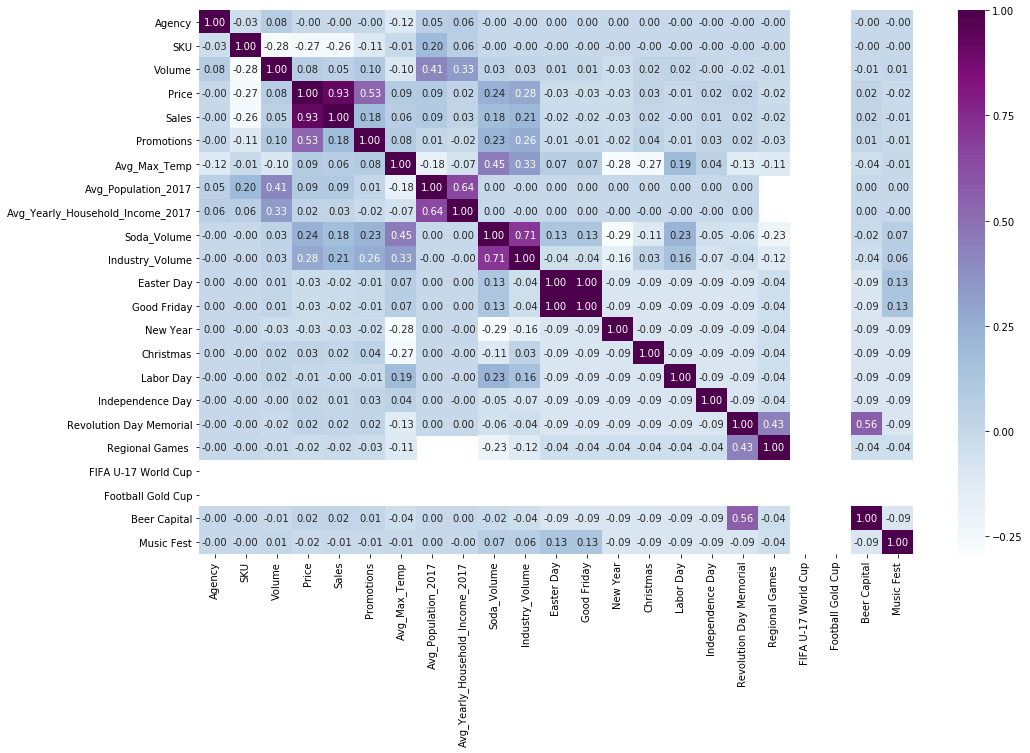

In [164]:
# df = df.drop('YearMonth', axis=1)
# df_temp = df
cols = list(df)

corr_ =df[cols].corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")
plt.savefig('../fig/Data Numeric Corr.png',bbox_inches='tight')

## 7.2 Feature Engineering

In [163]:
df = df.drop('Soda_Volume',axis=1)
df = df.drop('Good Friday',axis=1)
df = df.drop('Sales',axis=1)
df = df.drop('Revolution Day Memorial',axis=1)
df = df.drop('Independence Day',axis=1)
df = df.drop('Beer Capital',axis=1)
df = df.drop('New Year',axis=1)
df = df.drop('Avg_Max_Temp',axis=1)
df = df.drop('FIFA U-17 World Cup',axis=1)
df = df.drop('Football Gold Cup',axis=1)
df = df.drop('Avg_Population_2017',axis=1)
df = df.drop('Avg_Yearly_Household_Income_2017',axis=1)

In [164]:
df.isnull().sum()

Agency             0
SKU                0
YearMonth          0
Volume             0
Price              0
Promotions         0
Industry_Volume    0
Easter Day         0
Christmas          0
Labor Day          0
Regional Games     0
Music Fest         0
dtype: int64

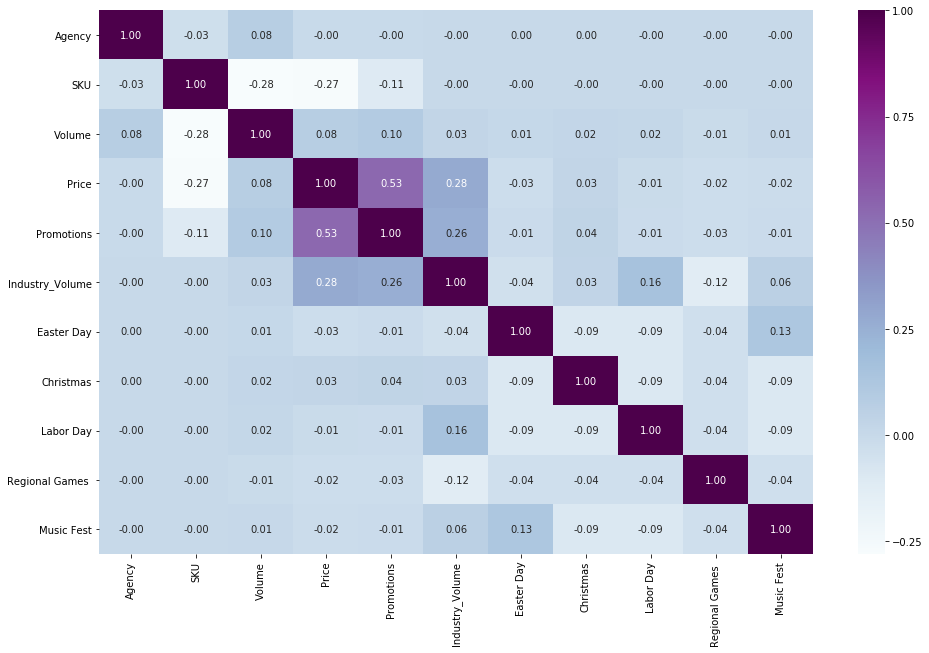

In [186]:
corr_ =df[list(df)].corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")
plt.savefig('../fig/Data Numeric Corr 2.png',bbox_inches='tight')

In [5]:
df = df[['YearMonth','Volume','Price','Promotions']].copy()
df.head()

,YearMonth,Volume,Price,Promotions
0,2013-01-01,52.27,1168.90,99.74
1,2013-01-01,31.06,1742.11,143.70
2,2013-01-01,238.54,1310.18,106.30
3,2013-01-01,110.70,1167.00,99.74
4,2013-01-01,86.46,1258.73,102.08


In [6]:
df = df.groupby('YearMonth')['Volume','Price','Promotions'].agg(['sum','mean','std']).reset_index()
df.head()

YearMonth     Volume                                Price               \
                     sum         mean          std        sum         mean   
0  2013-01-01  420800.26  1202.286457  2068.967302  380813.99  1088.039971   
1  2013-02-01  458964.04  1311.325829  2245.534754  383048.58  1094.424514   
2  2013-03-01  523473.88  1495.639657  2523.213543  392857.41  1122.449743   
3  2013-04-01  548346.92  1566.705486  2713.624659  406030.87  1160.088200   
4  2013-05-01  595946.40  1702.704000  2941.199611  411584.73  1175.956371   

              Promotions                        
          std        sum       mean        std  
0  566.527413   28145.86  80.416743  95.507102  
1  559.732076   24530.76  70.087886  70.148346  
2  567.968869   26050.54  74.430114  70.393990  
3  587.328397   27030.64  77.230400  74.308174  
4  580.454259   30289.36  86.541029  79.911797

In [7]:
df.columns = ['YearMonth','v_sum','v_mean','v_std','p_sum','p_mean','p_std','pr_sum','pr_mean','pr_std']

In [8]:
len(df)

60

In [11]:
df = df.sort_values('YearMonth', ascending=True).reset_index(drop=True)
df['YearMonth'] = pd.to_datetime(df['YearMonth'])
df = df.merge(df2, on='YearMonth', how='inner')
df.head()

,YearMonth,v_sum,v_mean,v_std,p_sum,p_mean,p_std,pr_sum,pr_mean,pr_std,...,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
0,2013-01-01,420800.26,1202.286457,2068.967302,380813.99,1088.039971,566.527413,28145.86,80.416743,95.507102,...,1,0,0,0,0,0,0,0,0,0
1,2013-02-01,458964.04,1311.325829,2245.534754,383048.58,1094.424514,559.732076,24530.76,70.087886,70.148346,...,0,0,0,0,0,0,0,0,0,0
2,2013-03-01,523473.88,1495.639657,2523.213543,392857.41,1122.449743,567.968869,26050.54,74.430114,70.393990,...,0,0,0,0,0,0,0,0,0,1
3,2013-04-01,548346.92,1566.705486,2713.624659,406030.87,1160.088200,587.328397,27030.64,77.230400,74.308174,...,0,0,0,0,0,0,0,0,0,0
4,2013-05-01,595946.40,1702.704000,2941.199611,411584.73,1175.956371,580.454259,30289.36,86.541029,79.911797,...,0,0,1,0,0,0,0,0,0,0


In [13]:
df = df.drop('Good Friday',axis=1)
df = df.drop('Revolution Day Memorial',axis=1)
df = df.drop('Independence Day',axis=1)
df = df.drop('Beer Capital',axis=1)
df = df.drop('New Year',axis=1)
df = df.drop('FIFA U-17 World Cup',axis=1)
df = df.drop('Football Gold Cup',axis=1)

In [14]:
data = df
data= data.drop('YearMonth', axis=1)
data.head(2)

,v_sum,v_mean,v_std,p_sum,p_mean,p_std,pr_sum,pr_mean,pr_std,Easter Day,Christmas,Labor Day,Regional Games,Music Fest
0,420800.26,1202.286457,2068.967302,380813.99,1088.039971,566.527413,28145.86,80.416743,95.507102,0,0,0,0,0
1,458964.04,1311.325829,2245.534754,383048.58,1094.424514,559.732076,24530.76,70.087886,70.148346,0,0,0,0,0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 14 columns):
v_sum              60 non-null float64
v_mean             60 non-null float64
v_std              60 non-null float64
p_sum              60 non-null float64
p_mean             60 non-null float64
p_std              60 non-null float64
pr_sum             60 non-null float64
pr_mean            60 non-null float64
pr_std             60 non-null float64
Easter Day         60 non-null int64
Christmas          60 non-null int64
Labor Day          60 non-null int64
Regional Games     60 non-null int64
Music Fest         60 non-null int64
dtypes: float64(9), int64(5)
memory usage: 7.0 KB


In [16]:
len(list(data))

14

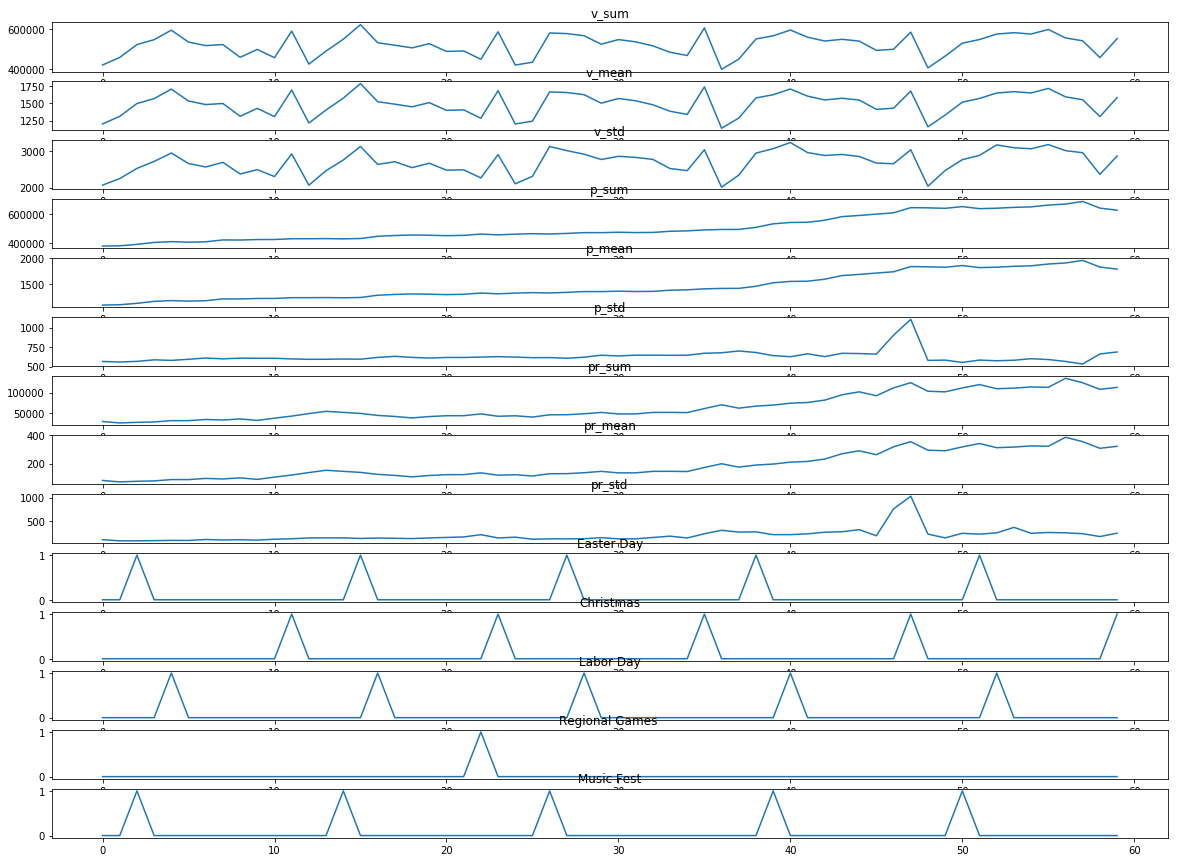

In [17]:
fig,ax = plt.subplots(14,1,figsize=(20,15))
for i,column in enumerate([col for col in data.columns if col != 'wnd_dir']):
    data[column].plot(ax=ax[i])
    ax[i].set_title(column)
plt.savefig('../fig/Dataset1.png',bbox_inches='tight')

## 7.3 Modelling 

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [147]:
values = data.values
print(values.shape)
values = values.astype('float32')
series_to_supervised(values,1,1).head()

(60, 14)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t)
1,420800.25000,1202.286499,2068.967285,380814.00000,1088.039917,566.527405,28145.859375,80.416740,95.507103,0.0,...,1094.424561,559.732056,24530.759766,70.087883,70.148346,0.0,0.0,0.0,0.0,0.0
2,458964.03125,1311.325806,2245.534668,383048.59375,1094.424561,559.732056,24530.759766,70.087883,70.148346,0.0,...,1122.449707,567.968872,26050.539062,74.430115,70.393990,1.0,0.0,0.0,0.0,1.0
3,523473.87500,1495.639648,2523.213623,392857.40625,1122.449707,567.968872,26050.539062,74.430115,70.393990,1.0,...,1160.088257,587.328369,27030.640625,77.230400,74.308174,0.0,0.0,0.0,0.0,0.0
4,548346.93750,1566.705444,2713.624756,406030.87500,1160.088257,587.328369,27030.640625,77.230400,74.308174,0.0,...,1175.956421,580.454285,30289.359375,86.541031,79.911797,0.0,0.0,1.0,0.0,0.0
5,595946.37500,1702.703979,2941.199707,411584.71875,1175.956421,580.454285,30289.359375,86.541031,79.911797,0.0,...,1164.892456,594.513672,30240.439453,86.401260,78.855370,0.0,0.0,0.0,0.0,0.0


In [148]:
reframed = series_to_supervised(values,1,1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
print(len(list(reframed)))
reframed.head()

15


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var1(t)
1,420800.25000,1202.286499,2068.967285,380814.00000,1088.039917,566.527405,28145.859375,80.416740,95.507103,0.0,0.0,0.0,0.0,0.0,458964.03125
2,458964.03125,1311.325806,2245.534668,383048.59375,1094.424561,559.732056,24530.759766,70.087883,70.148346,0.0,0.0,0.0,0.0,0.0,523473.87500
3,523473.87500,1495.639648,2523.213623,392857.40625,1122.449707,567.968872,26050.539062,74.430115,70.393990,1.0,0.0,0.0,0.0,1.0,548346.93750
4,548346.93750,1566.705444,2713.624756,406030.87500,1160.088257,587.328369,27030.640625,77.230400,74.308174,0.0,0.0,0.0,0.0,0.0,595946.37500
5,595946.37500,1702.703979,2941.199707,411584.71875,1175.956421,580.454285,30289.359375,86.541031,79.911797,0.0,0.0,1.0,0.0,0.0,536045.06250


In [149]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)
reframed.drop(reframed.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var1(t)
1,0.096053,0.096054,0.046510,0.000000,0.000000,0.056724,0.032576,0.032576,0.026383,0.0,0.0,0.0,0.0,0.0,0.265923
2,0.265923,0.265923,0.191819,0.007304,0.007304,0.044798,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.553060
3,0.553060,0.553060,0.420339,0.039365,0.039366,0.059254,0.013695,0.013695,0.000256,1.0,0.0,0.0,0.0,1.0,0.663772
4,0.663772,0.663772,0.577040,0.082425,0.082425,0.093231,0.022527,0.022527,0.004328,0.0,0.0,0.0,0.0,0.0,0.875640
5,0.875640,0.875640,0.764326,0.100578,0.100578,0.081166,0.051891,0.051891,0.010158,0.0,0.0,1.0,0.0,0.0,0.609015


In [150]:
values = reframed.values
n_train = 49
train = values[:n_train]
test = values[n_train:]
trainX,trainY = train[:,:-1],train[:,-1]
testX,testY = test[:,:-1],test[:,-1]

print(trainX.shape,trainY.shape,testX.shape,testY.shape)

trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])


print(trainX.shape)
print(testX.shape)

(49, 14) (49,) (10, 14) (10,)
(49, 1, 14)
(10, 1, 14)


In [151]:
len(testX)

10

In [152]:
stop_noimprovement = EarlyStopping(patience=10)
model = Sequential()
model.add(LSTM(50,input_shape=(trainX.shape[1],trainX.shape[2]),dropout=0.2))
model.add(Dense(1))
model.compile(loss="mae",optimizer="adam")

history= model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,verbose=2,callbacks=[stop_noimprovement],shuffle=False)


Train on 49 samples, validate on 10 samples
Epoch 1/100
 - 1s - loss: 0.5358 - val_loss: 0.6455
Epoch 2/100
 - 0s - loss: 0.5230 - val_loss: 0.6140
Epoch 3/100
 - 0s - loss: 0.5038 - val_loss: 0.5826
Epoch 4/100
 - 0s - loss: 0.4857 - val_loss: 0.5508
Epoch 5/100
 - 0s - loss: 0.4712 - val_loss: 0.5187
Epoch 6/100
 - 0s - loss: 0.4541 - val_loss: 0.4862
Epoch 7/100
 - 0s - loss: 0.4365 - val_loss: 0.4532
Epoch 8/100
 - 0s - loss: 0.4185 - val_loss: 0.4221
Epoch 9/100
 - 0s - loss: 0.3946 - val_loss: 0.3951
Epoch 10/100
 - 0s - loss: 0.3816 - val_loss: 0.3674
Epoch 11/100
 - 0s - loss: 0.3646 - val_loss: 0.3391
Epoch 12/100
 - 0s - loss: 0.3537 - val_loss: 0.3100
Epoch 13/100
 - 0s - loss: 0.3297 - val_loss: 0.2808
Epoch 14/100
 - 0s - loss: 0.3145 - val_loss: 0.2510
Epoch 15/100
 - 0s - loss: 0.2986 - val_loss: 0.2211
Epoch 16/100
 - 0s - loss: 0.2894 - val_loss: 0.1911
Epoch 17/100
 - 0s - loss: 0.2778 - val_loss: 0.1612
Epoch 18/100
 - 0s - loss: 0.2493 - val_loss: 0.1381
Epoch 19/10

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


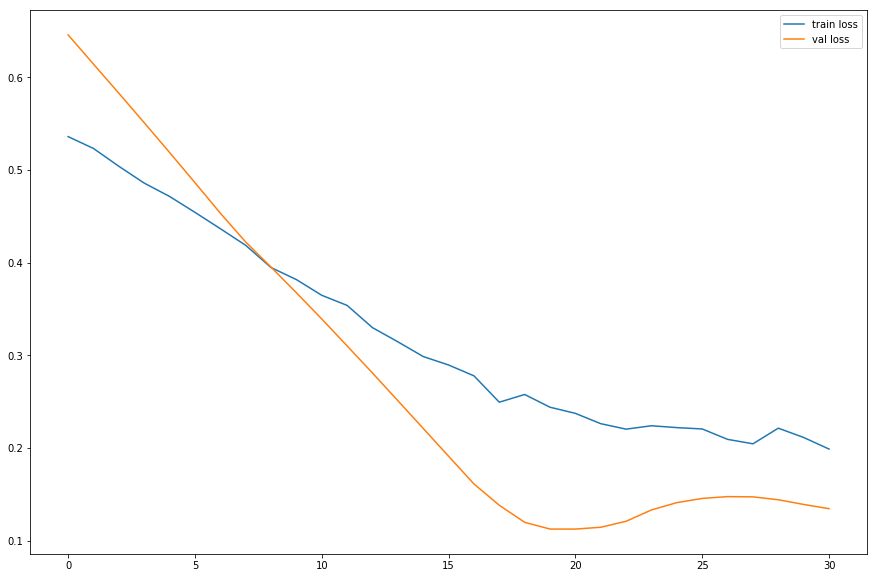

In [153]:
fig,ax =plt.subplots(figsize=(15,10))

plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
# plt.savefig('../fig/trai val forecasting.png',bbox_inches='tight')

 ### Predictions

In [154]:
len(testX)

10

In [155]:
predicted = model.predict(testX)

In [156]:
testXRe = testX.reshape(testX.shape[0],testX.shape[2])
predicted = np.concatenate((predicted,testXRe[:,1:]),axis=1)
print('predicted.shape : ',predicted.shape)

10

In [157]:
predicted = model.predict(testX)

testXRe = testX.reshape(testX.shape[0],testX.shape[2])
predicted = np.concatenate((predicted,testXRe[:,1:]),axis=1)
print('predicted.shape : ',predicted.shape)

predicted = scaler.inverse_transform(predicted)
testY = testY.reshape(len(testY),1)
print('testY.shape : ',testY.shape)

testY = np.concatenate((testY,testXRe[:,1:]),axis=1)
testY = scaler.inverse_transform(testY)

predicted.shape :  (10, 14)
testY.shape :  (10, 1)


In [158]:
pd.DataFrame(testY)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,530448.8125,1329.754517,2465.682373,639782.8125,1827.950684,584.073792,101859.382812,291.026794,134.070480,0.0,0.0,0.0,0.0,0.0
1,549023.3125,1515.568115,2760.887207,651680.0625,1861.942993,554.477722,111565.351562,318.758179,232.549179,0.0,0.0,0.0,0.0,1.0
2,576496.9375,1568.637817,2878.213135,637465.1250,1821.328857,584.416382,119940.000000,342.685669,214.319458,1.0,0.0,0.0,0.0,0.0
3,583330.6875,1647.134033,3163.117920,640510.8750,1830.031128,575.731689,109563.093750,313.037415,242.212662,0.0,0.0,1.0,0.0,0.0
4,576566.3750,1666.659058,3085.946533,646294.4375,1846.555298,582.527710,111085.718750,317.387756,359.760468,0.0,0.0,0.0,0.0,0.0
5,599553.6250,1647.332397,3057.682129,649807.1250,1856.591919,601.954346,113986.351562,325.675262,233.142944,0.0,0.0,0.0,0.0,0.0
6,556966.6875,1713.010376,3171.819336,662044.0000,1891.554321,591.269775,113111.210938,323.174896,250.193848,0.0,0.0,0.0,0.0,0.0
7,542554.1250,1591.333374,3006.407227,669059.5625,1911.598633,567.063049,135505.203125,387.157715,242.963486,0.0,0.0,0.0,0.0,0.0
8,457914.5000,1550.154419,2950.088379,686752.5625,1962.150269,534.206909,124444.148438,355.554718,224.354370,0.0,0.0,0.0,0.0,0.0
9,553316.1250,1308.327148,2360.948486,641378.8125,1832.510986,662.387695,108049.781250,308.713654,162.477158,0.0,0.0,0.0,0.0,0.0


In [159]:
np.sqrt(mean_squared_error(testY[:,0],predicted[:,0]))

43676.04

In [30]:
result = pd.concat([pd.Series(predicted[:,0]),pd.Series(testY[:,0])],axis=1)
result.columns = ['thetahat','theta']
result['diff'] = result['thetahat'] - result['theta']

In [31]:
result = pd.concat([pd.Series(predicted[:,0]),pd.Series(testY[:,0])],axis=1)
result.columns = ['thetahat','theta']
result['diff'] = result['thetahat'] - result['theta']

In [32]:
result.head()

,thetahat,theta,diff
0,533557.6250,530448.8125,3108.8125
1,599244.6875,549023.3125,50221.3750
2,602468.8125,576496.9375,25971.8750
3,605634.0625,583330.6875,22303.3750
4,584406.2500,576566.3750,7839.8750


## 8. Forecasting Unvariate

In [165]:
df_new = df[['YearMonth','Volume','Price','Promotions']].copy()
df_new.head()

,YearMonth,Volume,Price,Promotions
0,2013-01-01,52.27,1168.90,99.74
1,2013-01-01,31.06,1742.11,143.70
2,2013-01-01,238.54,1310.18,106.30
3,2013-01-01,110.70,1167.00,99.74
4,2013-01-01,86.46,1258.73,102.08


In [166]:
df_new = df_new.groupby('YearMonth')['Volume'].agg(['sum']).reset_index()
df_new.head()

,YearMonth,sum
0,2013-01-01,420800.26
1,2013-02-01,458964.04
2,2013-03-01,523473.88
3,2013-04-01,548346.92
4,2013-05-01,595946.40


In [168]:
df_new['YearMonth'] = pd.to_datetime(df_new['YearMonth'])
df_new = df_new.sort_values(by='YearMonth').reset_index(drop=True)
df_new = df_new.drop('YearMonth', axis=1)
df_new.head()

,sum
0,420800.26
1,458964.04
2,523473.88
3,548346.92
4,595946.40


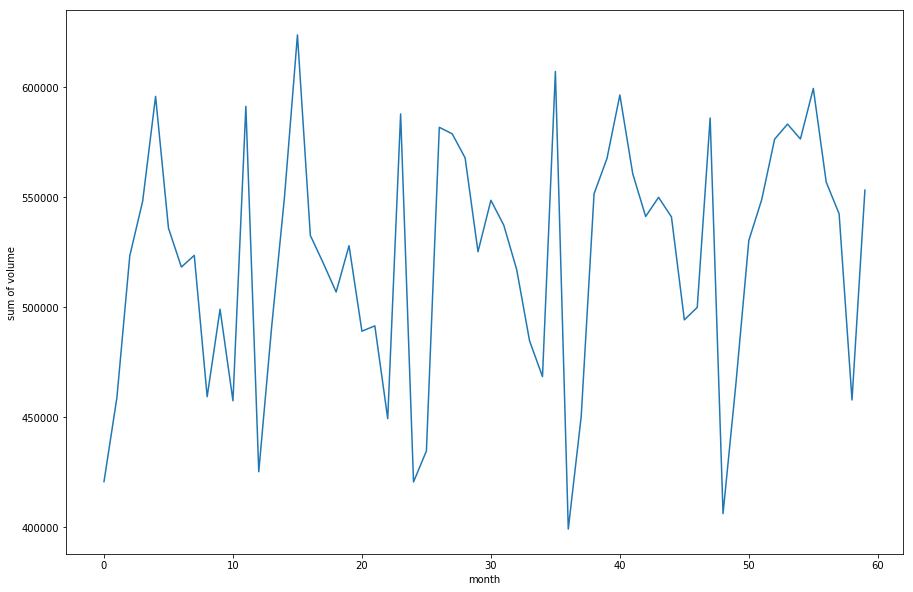

In [172]:
fig,ax =plt.subplots(figsize=(15,10))
plt.plot(df_new)
plt.xlabel('month')
plt.ylabel('sum of volume')
plt.savefig('../fig/forecasting unvariate 1.png',bbox_inches='tight')

In [183]:
train = df_new[0:50]
test = df_new[50:]

In [184]:
# load the trainset
train = train.values
train = train.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)

# load the testset
test = test.values
test = test.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
test = scaler.fit_transform(test)
print(test.shape)

(10, 1)


In [185]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [188]:
look_back = 1
testX, testY = create_dataset(test, look_back)


trainX, trainY = create_dataset(train, look_back)

In [189]:
trainX.shape

(48, 1)

In [190]:
trainY.shape

(48,)

In [191]:
testX.shape

(8, 1)

In [192]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [193]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

history= model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,verbose=2,callbacks=[stop_noimprovement],shuffle=False)


Train on 48 samples, validate on 8 samples
Epoch 1/100
 - 1s - loss: 0.3390 - val_loss: 0.5376
Epoch 2/100
 - 0s - loss: 0.3345 - val_loss: 0.5305
Epoch 3/100
 - 0s - loss: 0.3296 - val_loss: 0.5235
Epoch 4/100
 - 0s - loss: 0.3248 - val_loss: 0.5165
Epoch 5/100
 - 0s - loss: 0.3200 - val_loss: 0.5095
Epoch 6/100
 - 0s - loss: 0.3152 - val_loss: 0.5026
Epoch 7/100
 - 0s - loss: 0.3105 - val_loss: 0.4957
Epoch 8/100
 - 0s - loss: 0.3058 - val_loss: 0.4889
Epoch 9/100
 - 0s - loss: 0.3012 - val_loss: 0.4822
Epoch 10/100
 - 0s - loss: 0.2966 - val_loss: 0.4755
Epoch 11/100
 - 0s - loss: 0.2921 - val_loss: 0.4689
Epoch 12/100
 - 0s - loss: 0.2876 - val_loss: 0.4624
Epoch 13/100
 - 0s - loss: 0.2832 - val_loss: 0.4559
Epoch 14/100
 - 0s - loss: 0.2788 - val_loss: 0.4495
Epoch 15/100
 - 0s - loss: 0.2745 - val_loss: 0.4431
Epoch 16/100
 - 0s - loss: 0.2702 - val_loss: 0.4369
Epoch 17/100
 - 0s - loss: 0.2660 - val_loss: 0.4307
Epoch 18/100
 - 0s - loss: 0.2619 - val_loss: 0.4245
Epoch 19/100

In [195]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


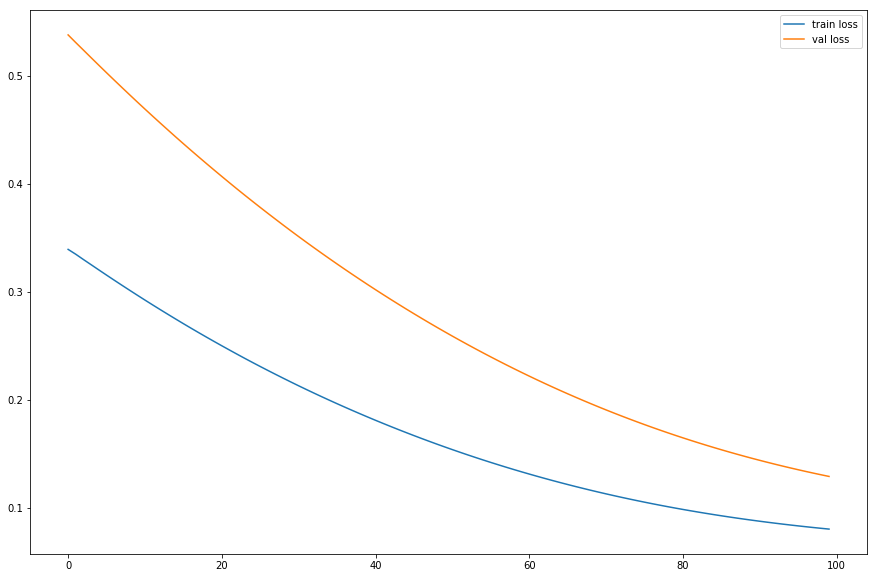

In [194]:
fig,ax =plt.subplots(figsize=(15,10))

plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.savefig('../fig/unvariate 1.png',bbox_inches='tight')

In [198]:
testPredict = model.predict(testX)
print(testPredict.shape)
testPredict = scaler.inverse_transform(testPredict)
testPredict

(8, 1)


array([[514746.56],
       [518949.  ],
       [525078.44],
       [526580.  ],
       [525093.75],
       [530098.44],
       [520734.22],
       [517489.1 ]], dtype=float32)

In [201]:
len(test)

10

In [205]:
test = df_new[55:]
test

,sum
55,599553.64
56,556966.68
57,542554.11
58,457914.49
59,553316.10


In [206]:
test.values

array([[599553.64],
       [556966.68],
       [542554.11],
       [457914.49],
       [553316.1 ]])

In [209]:
# load the testset
test = test.values
test = test.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
test = scaler.fit_transform(test)

In [211]:
test = np.expand_dims(test, axis=1)
test.shape

(5, 1, 1)

In [212]:
data= test
# data = np.expand_dims(data, axis=1)

print('data n',data)
print('\n')


predict = model.predict(data)
print('predict data n ',predict)
print('\n')


future = predict
future = np.expand_dims(future, axis=1)

future_predict = model.predict(future)
print('predict data n + 1 ',future_predict)

data n [[[0.99999976]]

 [[0.6993277 ]]

 [[0.5975723 ]]

 [[0.        ]]

 [[0.67355394]]]


predict data n  [[0.5096328 ]
 [0.44351935]
 [0.42060822]
 [0.28587985]
 [0.43773472]]


predict data n + 1  [[0.40068376]
 [0.3856623 ]
 [0.3804531 ]
 [0.34985107]
 [0.38434717]]


In [213]:
future_predict = scaler.inverse_transform(future_predict)
future_predict

array([[514667.  ],
       [512539.38],
       [511801.56],
       [507467.12],
       [512353.12]], dtype=float32)